In [1]:
from functools import partial
import torch
import matplotlib.pyplot as plt
import copy
import torchopt
from optree import tree_map, tree_reduce

import uqlib

torch.manual_seed(42);

# Continual Learning Regression - Problem Specification

We'll work with a very simple 1-dimensional input, 1-dimensional output regression task. We'll also assume where we are told the conditional standard deviation of the noise in the data. That is we have data $y_k \sim \mathcal{N}(y \mid f(x_k), \sigma_y^2)$ where we are given $\sigma_y$.

Our job is to learn $f(x)$. We will do so by parameterising a neural network $f_\theta(x)$ and learning the parameters $\theta$ that best fit the data.

We also assume a continual learning setting where we recieve data in (discrete time) episodes $\{x_{ep, k}, y_{ep, k} \}_{k=1}^{K}$ for $ep=1, \dots, N_{eps}$ where $K$ is the number of data points in episode and $N_{eps}$ is the number of episodes.

In a given episode, the training algorithm is only allowed access to the data in that episode. It is not allowed to access data from previous episodes (unless it is maintaining a fixed dimenionsal coreset).
**The goal is to fit to new data without performance on old data deteriorating.**

In [2]:
n_episodes = 5
samps_per_episode = 20
y_sd = 0.2

In [3]:
def true_f(x):
    return torch.sin(x) + 0.5 * torch.sin(2 * x) + 0.1 * torch.sin(3 * x)

In [4]:
episode_x_boundaries = torch.linspace(0, n_episodes, n_episodes + 1)
xs = torch.stack([torch.linspace(episode_x_boundaries[i], episode_x_boundaries[i + 1], samps_per_episode) for i in range(n_episodes)])
ys = torch.stack([true_f(x) + y_sd * torch.randn_like(x) for x in xs])

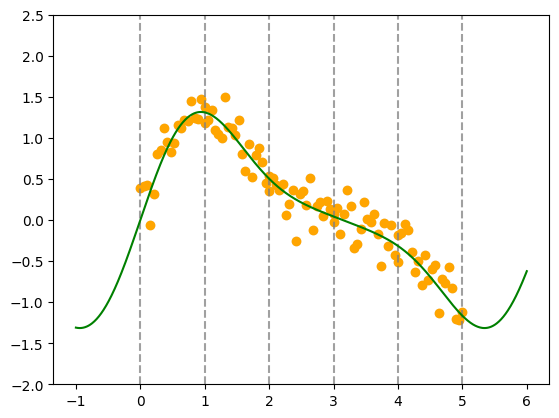

In [5]:
plt_linsp = torch.linspace(-1, episode_x_boundaries[-1] + 1, 1000)

def plot_data(ax, up_to_episode=None):
    if up_to_episode is None:
        up_to_episode = n_episodes
    
    ax.plot(xs.flatten(), ys.flatten(), 'o', color='gray', alpha=0.2)
    for i in range(up_to_episode):
        ax.plot(xs[i], ys[i], 'o', color='orange')
    
    for v in episode_x_boundaries:
        ax.axvline(v, color='gray', linestyle='--', alpha=0.75)
    ax.plot(plt_linsp, true_f(plt_linsp), color='green', zorder=10)
    ax.set_ylim(-2., 2.5)

fig, ax = plt.subplots()
plot_data(ax)

Here we can see the data from all 5 episodes and the true underlying function in green.

# Model

We'll just use a simple neural network with 2 hidden layers and ReLU activations..

In [6]:
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(1, 200)
        self.l2 = torch.nn.Linear(200, 200)
        self.l3 = torch.nn.Linear(200, 1)

    def forward(self, x):
        x = torch.nn.functional.relu(self.l1(x))
        x = torch.nn.functional.relu(self.l2(x))
        x = self.l3(x)
        return x

In [7]:
mlp = MLP()
mlp_functional = uqlib.model_to_function(mlp)


print("Num params:", sum([p.numel() for p in mlp.parameters()]))

Num params: 40801


In [8]:
def log_prior(p, prior_mean, prior_sd: float):
    all_vals = tree_map(lambda p, m, sd: torch.distributions.Normal(m, sd, validate_args=False).log_prob(p).sum(), p, prior_mean, prior_sd)
    return tree_reduce(torch.add, all_vals)
    
def log_likelihood(y_pred, y):
    return torch.distributions.Normal(y_pred, y_sd, validate_args=False).log_prob(y).mean()

In [9]:
def log_posterior(params, batch, prior_mean, prior_sd):
    x, y = batch
    y_pred = mlp_functional(params, x)
    log_post = log_likelihood(y_pred, y) + log_prior(params, prior_mean, prior_sd) / samps_per_episode
    return log_post, y_pred

The log posterior follows the uqlib API and outputs the value to be differentiated in the first arugment. The second argument can be an arbitrary TensorTree, here we'll retain the model's predictions.


The log posterior is normalised to give the same expected value independent of batch size. Technically it outputs the log of the posterior divided by total the number of data points in the training set (i.e. episode).
We can recover the true log posterior (in expectation) by setting `temperature = 1 / samps_per_episode` (`samps_per_episode` is the size of the training set in each episode).

# Continual learning (with catastrophic forgetting)

In this simple but perhaps naive approach we just continue doing SGD on the new data as a new episode starts and previous data is not touched again.

In [10]:
batch_size = 3
dataloaders = [torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x.unsqueeze(-1), y.unsqueeze(-1)), batch_size=batch_size) for x, y in zip(xs, ys)]

In [11]:
def train_for_map(dataloader, prior_mean, prior_sd, n_epochs=100):
    opt = torch.optim.Adam(mlp.parameters())
    for _ in range(n_epochs):
        for batch in dataloader:
            opt.zero_grad()
            loss = -log_posterior(dict(mlp.named_parameters()), batch, prior_mean, prior_sd)[0]
            loss.backward()
            opt.step()

In [12]:
prior_mean = tree_map(torch.zeros_like, dict(mlp.named_parameters()))
prior_sd = tree_map(torch.ones_like, dict(mlp.named_parameters()))
trained_params = []
for i in range(n_episodes):
    train_for_map(dataloaders[i], prior_mean, prior_sd)
    trained_params += [copy.deepcopy(mlp.state_dict())]

In [13]:
def plot_predictions(params, ax, x, sd=y_sd, alpha=1.):
    preds = mlp_functional(params, x.unsqueeze(-1)).detach().numpy().squeeze()
    ax.plot(x, preds, color='blue', alpha=alpha)
    ax.fill_between(x, preds - sd, preds + sd, color='blue', alpha=0.2)

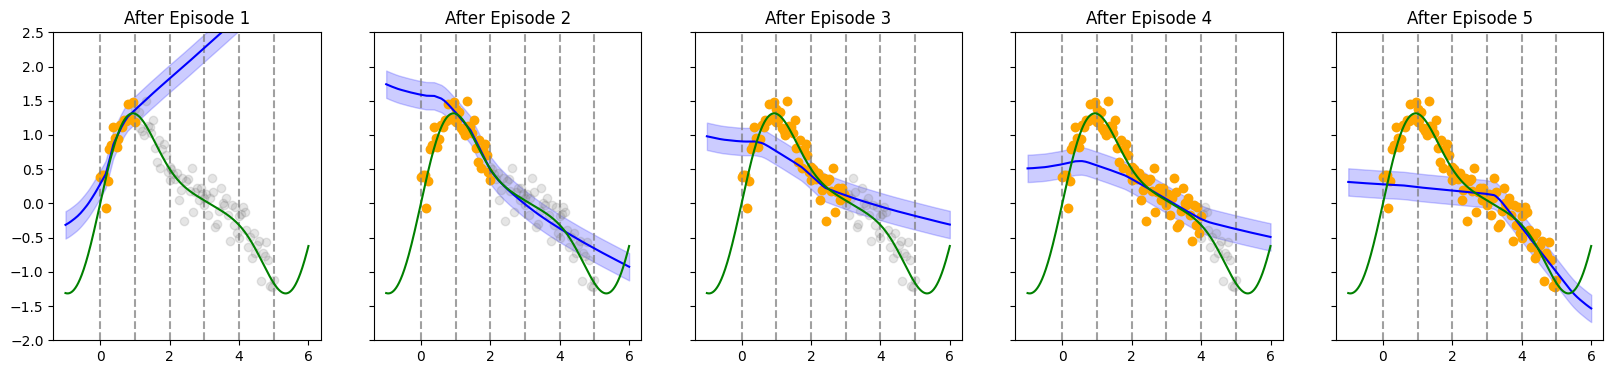

In [14]:
fig, axes = plt.subplots(1, n_episodes, figsize=(n_episodes * 4, 4), sharex=True, sharey=True)

for i, ax in enumerate(axes):
    plot_data(ax, up_to_episode=i+1)
    plot_predictions(trained_params[i], ax, plt_linsp)
    ax.set_title(f"After Episode {i+1}")

We can see that at each episode we have good performance on the latest task but we forget the previous ones.

# Variational Continual Learning

Now we'll be Bayesian and update a variational posterior distribution over the parameters at each episode following the [Variational Continual Learning](https://arxiv.org/abs/1710.10628) approach.



In [15]:
transition_sd = 0.1

In [16]:
def train_for_vi(dataloader, prior_mean, prior_sd, n_epochs=200, init_log_sds=None):
    seq_log_post = partial(log_posterior, prior_mean=prior_mean, prior_sd=prior_sd)
    optimizer = torchopt.adam(lr=2e-3)
    transform = uqlib.vi.diag.build(seq_log_post, optimizer, temperature=1/samps_per_episode, init_log_sds=init_log_sds, stl=False)
    state = transform.init(dict(mlp.named_parameters()))
    nelbos = []
    for _ in range(n_epochs):
        for batch in dataloader:
            state = transform.update(state, batch, inplace=False)
            nelbos.append(state.nelbo)
    return state, nelbos

Here we use `uqlib.vi.diag` but it would be possible to swap it out for example `uqlib.ekf.diag_fisher` for example.

In [17]:
mlp.load_state_dict(trained_params[0])
vi_states = []
nelbos = []
for i in range(n_episodes):
    seq_prior_mean = prior_mean if i == 0 else vi_states[i - 1].params
    seq_prior_sd = prior_sd if i == 0 else tree_map(lambda lsd: torch.sqrt(torch.exp(lsd) ** 2 + transition_sd ** 2), vi_states[i - 1].log_sd_diag)
    seq_log_sds = tree_map(lambda x: torch.zeros_like(x) - 6., mlp.state_dict())
    state, nelbos_i = train_for_vi(dataloaders[i], seq_prior_mean, seq_prior_sd, init_log_sds=seq_log_sds)
    vi_states += [state]
    nelbos += [nelbos_i]
    mlp.load_state_dict(vi_states[i].params)

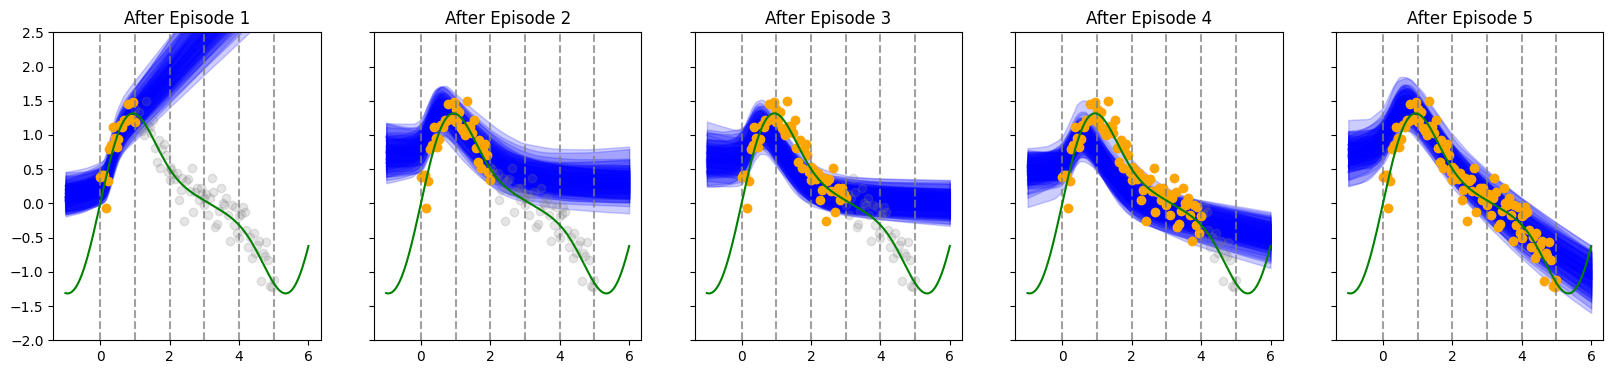

In [19]:
fig, axes = plt.subplots(1, n_episodes, figsize=(n_episodes * 4, 4), sharex=True, sharey=True)

n_samples = 20

for i, ax in enumerate(axes):
    for _ in range(n_samples):
        sample = uqlib.vi.diag.sample(vi_states[i])
        plot_predictions(sample, ax, plt_linsp, sd=y_sd, alpha=0.2)
    plot_data(ax, up_to_episode=i+1)
    ax.set_title(f"After Episode {i+1}")

This is much improved. But there are still a few issues!

- We still have some forgetting (even in this simple setting), our performance on task one and two is still worse after episode six that it was at the time.
- Performance is very susceptible to the choice of the episoidal prior variance `transition_sd`. Perhaps we can learn this automatically?